# Train/fine-tune a model to predict tree crowns

In this notebook, we will first assess how well the pre-trained model from the [DeepForest](https://deepforest.readthedocs.io/en/latest/) package [1] performs on our dataset. We will then fine-tune the model using our annotations and compare the performance.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from os import path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from deepforest import main, utilities

from swiss_urban_trees import deepforest_utils, plot

/home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
annot_df_filepath = "../data/raw/sitg-orthophoto-2019-tiles/annot.csv"
tile_dir = "../data/raw/sitg-orthophoto-2019-tiles"
dst_model_filepath = "../models/fine-tuned.pl"

# model args
num_workers = 4
patch_overlap = 0.1
patch_sizes = [400, 600, 800, 1000]
iou_threshold = 0.15

# viz args
annot_color = "orange"
pred_color = "orange"
_base_plot_kwargs = {"linewidth": 2}
plot_annot_kwargs = dict({"color": annot_color}, **_base_plot_kwargs)
plot_pred_kwargs = dict({"color": pred_color}, **_base_plot_kwargs)
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

# eval args
iou_threshold = 0.4

# train args
epochs = 2
gpus = None  # set to -1 to use all available GPUs

## Read annotations

In [ ]:
# since we are only predicting crowns, relabel all the annotations to "Tree", and
# convert to gdf.
annot_gdf = utilities.read_file(
    pd.read_csv(annot_df_filepath).assign(**{"label": "Tree"})
)
annot_gdf.head()

,xmin,ymin,xmax,ymax,label,image_path,geometry
0,300.0,620.0,362.5,705.0,Tree,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((362.5 620, 362.5 705, 300 705, 300 6..."
1,332.5,80.0,375.0,117.5,Tree,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((375 80, 375 117.5, 332.5 117.5, 332...."
2,142.5,412.5,192.5,462.5,Tree,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((192.5 412.5, 192.5 462.5, 142.5 462...."
3,162.5,472.5,255.0,550.0,Tree,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((255 472.5, 255 550, 162.5 550, 162.5..."
4,227.5,447.5,325.0,525.0,Tree,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((325 447.5, 325 525, 227.5 525, 227.5..."


## Predict with the pre-trained model

We will start by loading the DeepForest tree crown detection model, which has been pretrained on over 30 million algorithmically generated crowns from 22 forests and fine-tuned using 10,000 hand-labelled crowns from six forests [1].

In [ ]:
model = main.deepforest(config_args={"workers": num_workers})
model.use_release()

Reading config file: /home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml
setting config workers to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


As [noted in the user guide](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/10_better.html#check-patch-size), the prebuilt model is trained on 400x400 images at a 10 cm resolution. Accordingly, the model is sensitive to the image resolution. As a rule of thumb, the "patch size" parameter used for prediction can be increased for higher resolution images. Since our data is at 25 cm resolution (instead of 10 cm of the prebuilt model), we can expect the model to perform better with patch sizes smaller than 400 pixels, but we will need to confirm this.

In [ ]:
# predict
img_filenames = pd.Series(annot_gdf["image_path"].unique())
pred_gdf = pd.concat(
    [
        model.predict_tile(
            path.join(tile_dir, img_filename),
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            iou_threshold=iou_threshold,
        ).assign(**{"patch_size": patch_size})
        for img_filename in img_filenames
        for patch_size in patch_sizes
    ],
    ignore_index=True,
)

Predicting DataLoader 0: 100%|███████████████████████| 49/49 [03:09<00:00,  0.26it/s]
602 predictions in overlapping windows, applying non-max supression
525 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|███████████████████████| 25/25 [01:19<00:00,  0.32it/s]
264 predictions in overlapping windows, applying non-max supression
206 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|███████████████████████| 16/16 [00:56<00:00,  0.28it/s]
121 predictions in overlapping windows, applying non-max supression
92 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|█████████████████████████| 9/9 [00:27<00:00,  0.32it/s]
64 predictions in overlapping windows, applying non-max supression
55 predictions kept after non-max suppression


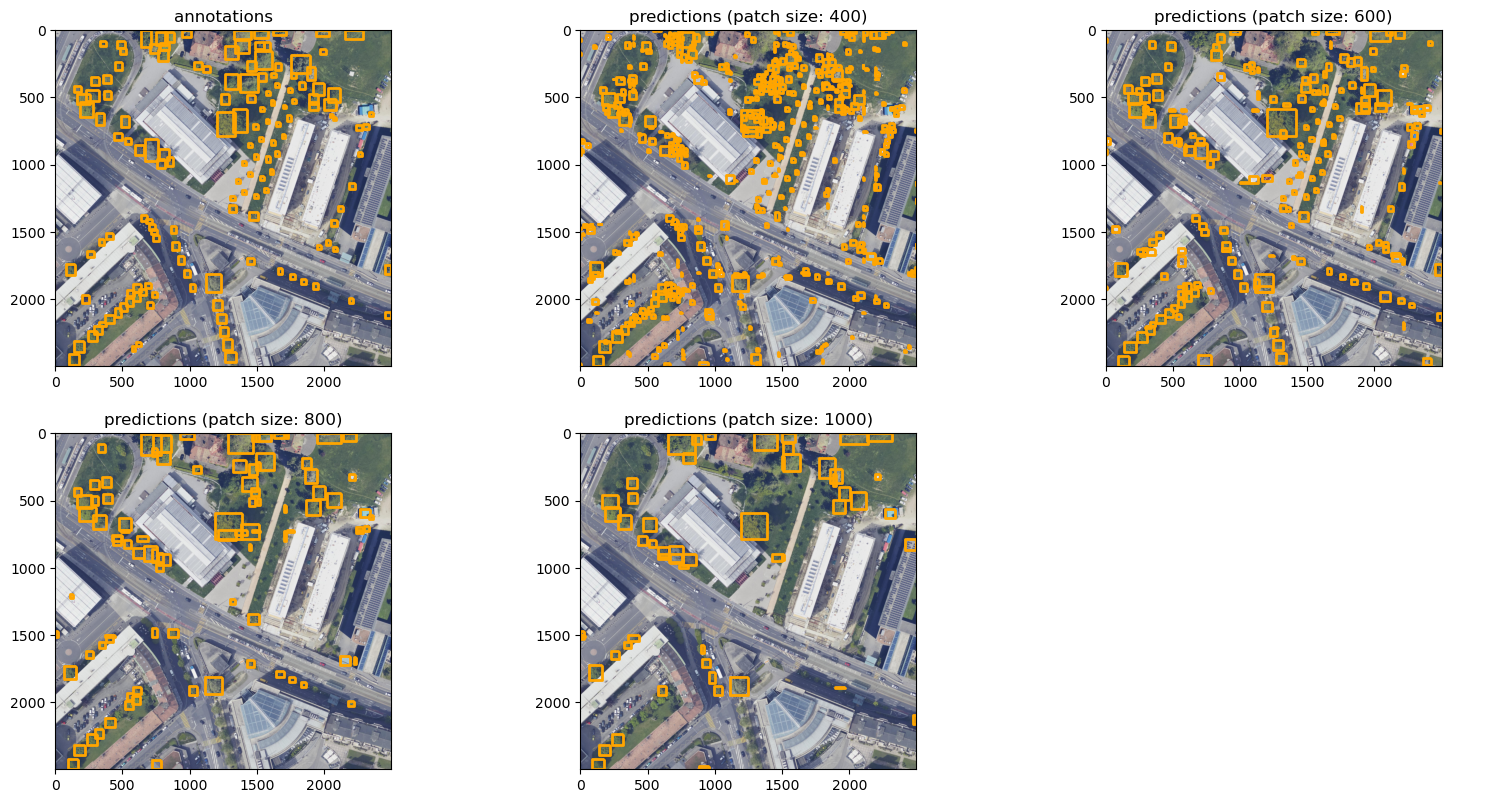

In [ ]:
fig = plot.plot_annot_vs_pred(
    annot_gdf,
    pred_gdf,
    tile_dir,
    legend=False,
    plot_annot_kwargs=plot_annot_kwargs,
    plot_pred_kwargs=plot_pred_kwargs,
)

At first glance, this seems a good zero-shot prediction and we can visually grasp that the model performs better with a patch size somewhere in between 400 and 600 pixels. Let us now use proper metrics to confirm this.

### Evaluate predictions from the pre-trained model

We will now compute the following metrics:
- **intersection over union (IoU)**: the proportion of the area of overlap between the predicted and annotated bounding boxes to the area of their union
- **precision**: the proportion of predicted objects that have a ground truth positive match (for a given IoU threshold)
- **recall**: the proportion of ground truth objects that have a true positive match (for a given IoU threshold)
- **F1**: the harmonic mean of precision and recall, providing a measure of model performance that balances true positives and false negatives.

In [ ]:
eval_df = deepforest_utils.multiscale_eval_df(
    pred_gdf, annot_gdf, tile_dir, compute_f1=True
)
eval_df

,patch_size,IoU,recall,precision,F1
0,400,0.533763,0.673469,0.234043,0.347368
1,600,0.545585,0.741497,0.529126,0.617564
2,800,0.297504,0.394558,0.630435,0.485356
3,1000,0.183726,0.238095,0.653846,0.349076


While the precision monotonically increases with the patch size, it does so at the expense of recall. This occurs because less tree crowns are being predicted, however a higher proportion of them is matched to a ground truth (hence the higher precision). On the other hand, the recall peaks for the patch size of 600 px, which coincides with the best mean IoU, F1 as well as visual outputs. We can also show the metrics for each patch size as a bar plot:

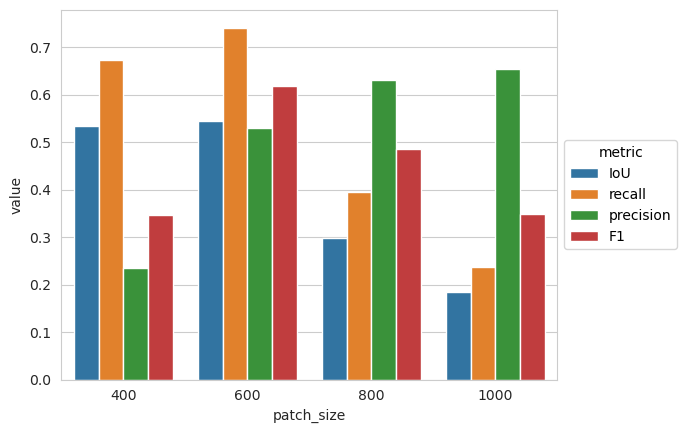

In [ ]:
with sns.axes_style("whitegrid"):
    ax = plot.metrics_barplot(eval_df)
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

## Train/fine-tune the pre-trained model

Let us now retrain the model using the annotations. Note that since we only have one annotated image, it most likely makes sense to use a small number of epochs.

In [ ]:
# retrain model for tree crowns only
model = deepforest_utils.retrain_model(
    model, tile_dir, annot_gdf, epochs=epochs, gpus=gpus
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | model      | RetinaNet             | 32.1 M | eval 
1 | iou_metric | IntersectionOverUnion | 0      | train
2 | mAP_metric | MeanAveragePrecision  | 0      | train
-------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
2         Modules in train mode
202       Modules in eval mode


Epoch 0:   0%|                                                 | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|███████████████████████████████| 1/1 [00:09<00:00,  0.10it/s, v_num=72]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|███████████████████████████████| 1/1 [00:09<00:00,  0.10it/s, v_num=72]
--- Model retrained in 18.68 seconds ---


In [ ]:
# pred_df[pred_df["image_path"] == img_filename]
# print(pred_df["image_path"].unique(), annot_df["image_path"].unique())
retrain_pred_df = pd.concat(
    [
        model.predict_tile(
            path.join(tile_dir, img_filename),
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            iou_threshold=iou_threshold,
        ).assign(**{"patch_size": patch_size})
        for img_filename in img_filenames
        for patch_size in patch_sizes
    ]
)

Predicting DataLoader 0: 100%|███████████████████████| 49/49 [02:19<00:00,  0.35it/s]
898 predictions in overlapping windows, applying non-max supression
797 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|███████████████████████| 25/25 [01:06<00:00,  0.38it/s]
462 predictions in overlapping windows, applying non-max supression
372 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|███████████████████████| 16/16 [00:41<00:00,  0.39it/s]
318 predictions in overlapping windows, applying non-max supression
225 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|█████████████████████████| 9/9 [00:23<00:00,  0.39it/s]
194 predictions in overlapping windows, applying non-max supression
142 predictions kept after non-max suppression


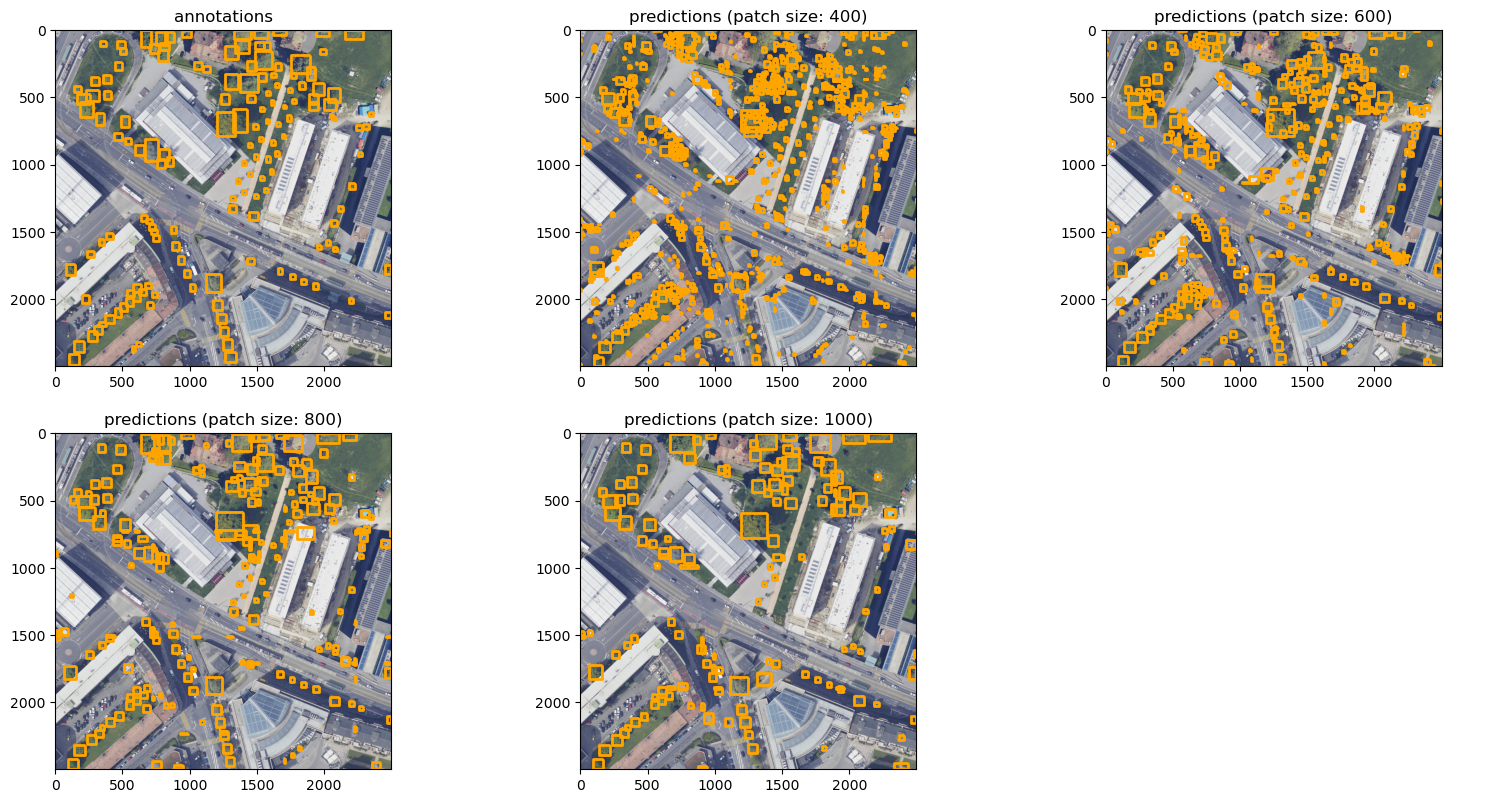

In [ ]:
# plot annotations and retrained model predictions with different patch sizes
fig = plot.plot_annot_vs_pred(
    annot_gdf,
    retrain_pred_df,
    tile_dir,
    plot_annot_kwargs=plot_annot_kwargs,
    plot_pred_kwargs=plot_pred_kwargs,
)

### Evaluate predictions from the fine-tuned model

**ACHTUNG**: note that we will be evaluating the predictions over the same tile used for training/fine-tuning, which should be avoided as it can result in issues such as *overfitting* and giving *highly misleading* impression of model performance. Ideally, we should *always* evaluate on test data that the model has not seen during training. However, providing high quality manual annotations is time consuming and at the current moment this notebook is mainly intended for illustrative purposes.

In [ ]:
retrain_eval_df = deepforest_utils.multiscale_eval_df(
    retrain_pred_df, annot_gdf, tile_dir, compute_f1=True
)
retrain_eval_df

,patch_size,IoU,recall,precision,F1
0,400,0.492553,0.625850,0.176583,0.275449
1,600,0.618953,0.857143,0.459559,0.598325
2,800,0.545565,0.755102,0.549505,0.636103
3,1000,0.424443,0.578231,0.613139,0.595174


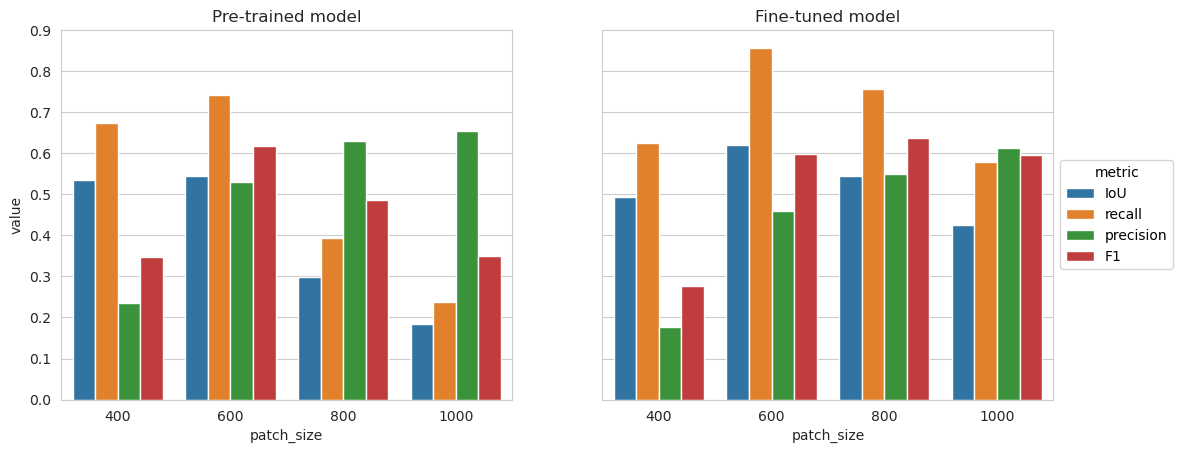

In [ ]:
# side-by-side comparison of metrics
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight), sharey=True)
    for df, title, legend, ax in zip(
        [eval_df, retrain_eval_df],
        ["Pre-trained model", "Fine-tuned model"],
        [False, True],
        axes,
    ):
        plot.metrics_barplot(df, ax=ax, legend=legend)
        ax.set_title(title)
# move the legend outside the last axis
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

As we can see, the fine-tuning overall improves the IoU and recall at the expense of a downgrade in the precision, likely because more predictions occur with the fine-tuned model. The best F1 score is now with the patch size of 800 px, which is higher than any F1 score obtained with the pre-trained model. Let us conclude by saving the fine-tuned model checkpoint:

In [ ]:
model.trainer.save_checkpoint(dst_model_filepath)

## References

1. Weinstein, B. G., Marconi, S., Aubry‐Kientz, M., Vincent, G., Senyondo, H., & White, E. P. (2020). DeepForest: A Python package for RGB deep learning tree crown delineation. Methods in Ecology and Evolution, 11(12), 1743-1751.